<a href="https://colab.research.google.com/github/dkmachinelearning/dkmachinelearning/blob/main/Pipelines/Titanic/Titanic_pipeline_excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [469]:
# Basecode from https://blog.prokulski.science/2020/10/10/pipeline-w-scikit-learn/
import pandas as pd

# być może coś narysujemy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [470]:
# !pip install catboost
# !pip install dask[dataframe]
# !pip install scikit-learn==1.5.2

In [471]:
from sklearn.model_selection import train_test_split

# modele
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# preprocessing
## zmienne ciągłe
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
## zmienne kategoryczne
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# dodatkowe modele spoza sklearn
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [472]:
data = pd.read_csv("/content/train.csv")

In [473]:
data.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [474]:
import missingno as msno

In [475]:
data.shape

(891, 12)

<Axes: >

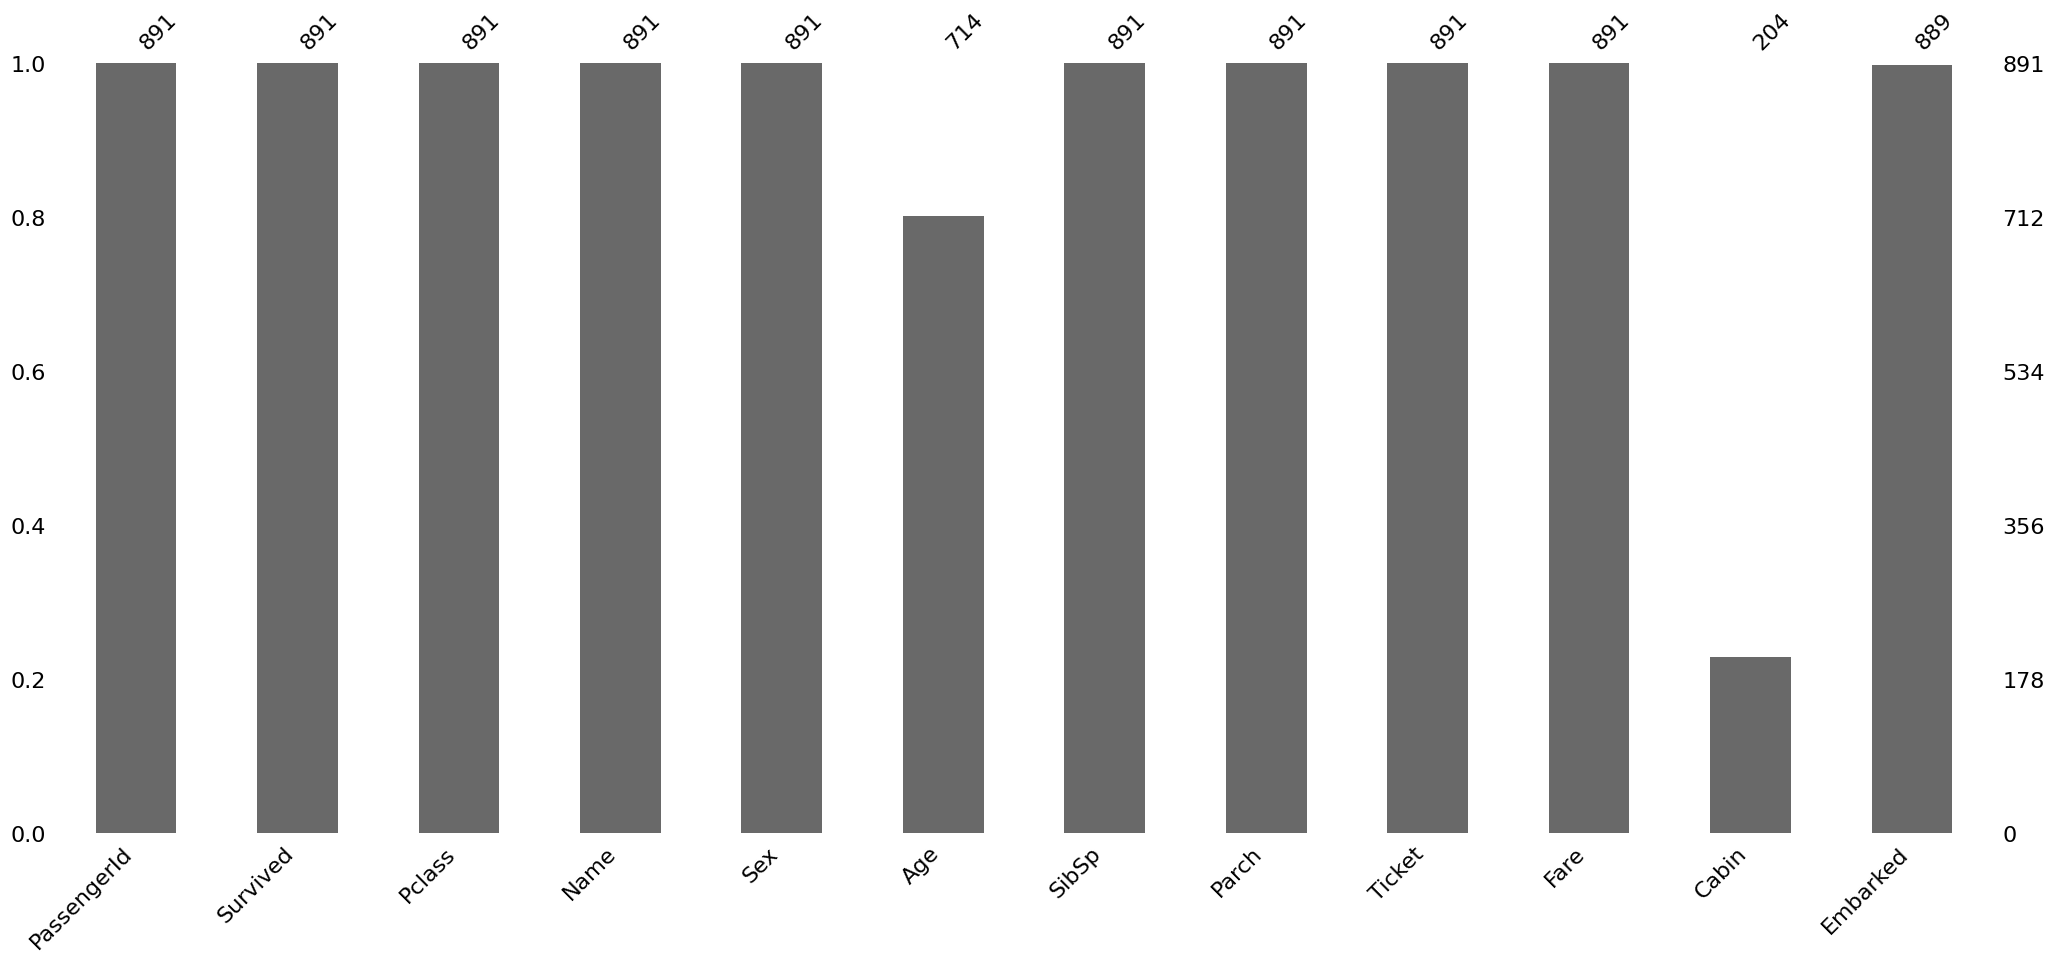

In [476]:
msno.bar(data)

In [477]:
#droping cabin and imputing issing values for age feature
data.drop('Cabin', axis = 1, inplace=True)


In [478]:
data['Age'].fillna(data['Age'].mean(), inplace=True)

<ipython-input-478-d2ec63e3eed6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].mean(), inplace=True)


In [479]:
# sns.boxplot(data=data, x='Age')

In [480]:
data['Age'] = data['Age'].astype('int64')

In [481]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.544332,0.523008,0.381594,NaN,32.204208,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.013778,1.102743,0.806057,NaN,49.693429,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,29.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN


In [482]:
data['Ticket'].value_counts()

,count
Ticket,
347082,7
CA. 2343,7
1601,7
3101295,6
CA 2144,6
...,...
9234,1
19988,1
2693,1


In [483]:
# split the column 'Ticket'
Ticket_split = []
Ticket_len = []
for i in data['Ticket'].index:
    splitted = data.loc[i,'Ticket'].split(' ')
    Ticket_split.append(splitted)
    length = len(splitted)
    Ticket_len.append(length)

data['Ticket_split'] = Ticket_split
data['Ticket_len'] = Ticket_len

# data[['Ticket_len']].value_counts()
# data.loc[data['Ticket_len'] > 2, :] We can see tome typo errors.

# Create columns Ticket_preffix and Ticket_number
ticket_preffix = []
ticket_number = []
for i in data['Ticket'].index:
    ticket_parts = data.loc[i, 'Ticket_split']
    number = ticket_parts[-1]
    ticket_number.append(number)
    length = data.loc[i, 'Ticket_len'].item()
    if length > 1:
        preffix = ''.join(ticket_parts[0:-1])
        ticket_preffix.append(preffix)
    else:
        ticket_preffix.append('blanck')

data['Ticket_preffix'] = ticket_preffix
data['Ticket_number'] = ticket_number
# drop unnecessary columns created
data.drop(columns=['Ticket_split', 'Ticket_len'], inplace=True)

data.Ticket_preffix.unique()

array(['A/5', 'PC', 'STON/O2.', 'blanck', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON'], dtype=object)

In [484]:
#Companions
n_alone , n_duplicates = data['Ticket'].duplicated(keep=False).astype(int).value_counts()
print("Number of duplicated ticket values:", n_duplicates)
print("Number of non-duplicated ticket values:", n_alone)
data['Companions'] = data['Ticket'].duplicated(keep=False).astype(int) * data.groupby('Ticket')['Ticket'].transform('count') -1
data.loc[data['Companions'] == -1, 'Companions'] = 0

Number of duplicated ticket values: 344
Number of non-duplicated ticket values: 547


In [485]:
#Family size feature
data['FamilySize'] = data['SibSp'] + data['Parch']
print(data[['SibSp','Parch','FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by = 'Survived'))

   FamilySize     SibSp     Parch  Survived
7           7  4.333333  2.666667  0.000000
8          10  8.000000  2.000000  0.000000
5           5  2.818182  2.181818  0.136364
4           4  2.133333  1.866667  0.200000
0           0  0.000000  0.000000  0.303538
6           6  3.250000  2.750000  0.333333
1           1  0.763975  0.236025  0.552795
2           2  0.872549  1.127451  0.578431
3           3  1.344828  1.655172  0.724138


In [486]:
data.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,int64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


<Axes: >

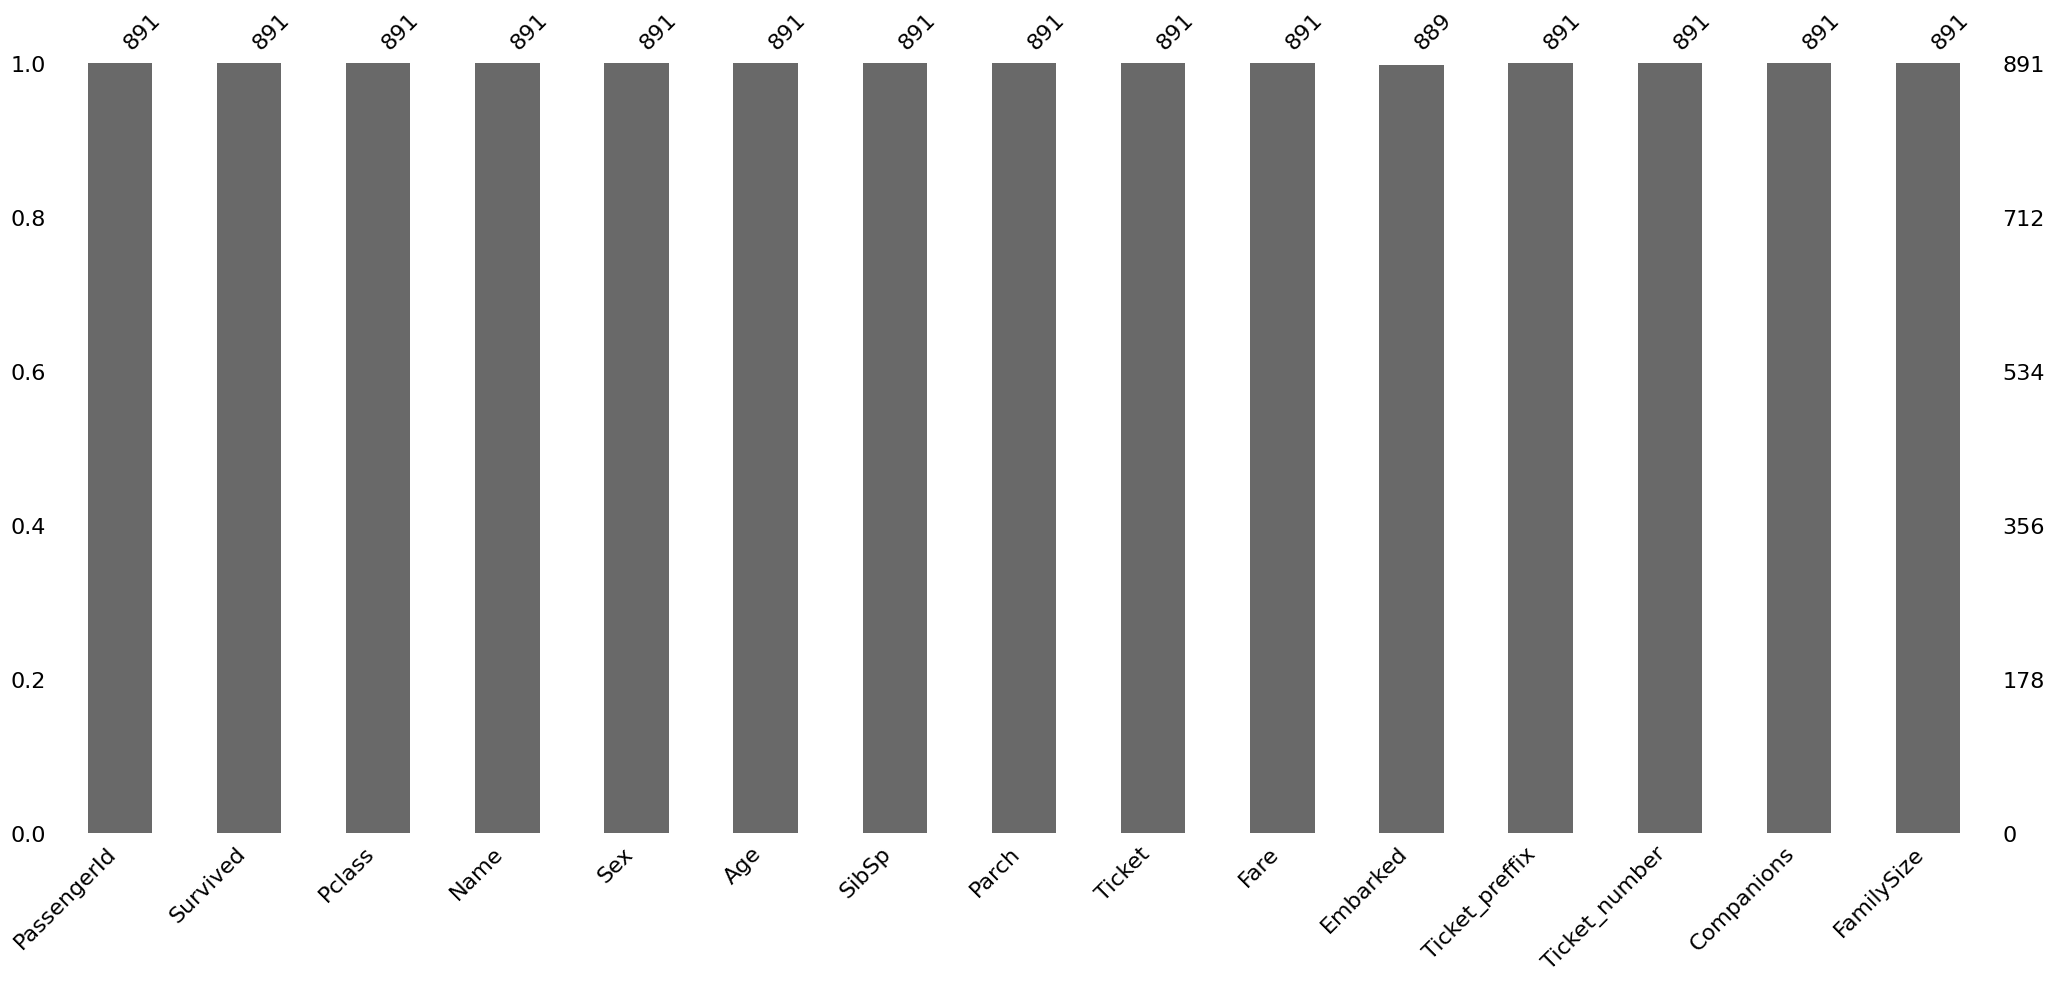

In [487]:
msno.bar(data)

In [488]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Ticket_preffix', 'Ticket_number'], axis=1),
                                                    data['Survived'],
                                                    test_size=0.3,
                                                    random_state=42)

In [489]:
# lista kolumn numerycznych
cols_numerical = X_train.select_dtypes(exclude=['object']).columns

# transformer dla kolumn numerycznych
transformer_numerical = Pipeline(steps = [
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ('num_trans', StandardScaler())
])

In [490]:
cols_numerical

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Companions', 'FamilySize'], dtype='object')

In [491]:
# lista kolumn kategorycznych
cols_categorical = X_train.select_dtypes(include=['object']).columns

# transformer dla kolumn numerycznych
transformer_categorical = Pipeline(steps = [
     ("imputation_constant", SimpleImputer(fill_value="missing", strategy="constant") ),
     ('cat_trans', OneHotEncoder())
])

In [492]:
cols_categorical

Index(['Sex', 'Embarked'], dtype='object')

In [493]:
# preprocesor danych
preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)
])

In [494]:
pipe = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier())
            ])

In [495]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('num_trans',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Companions', 'FamilySize'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_trans',
                                                                   OneHotEncoder())]),
                                                  Index(['Sex', 'Embarked'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [496]:
pipe.predict(X_test)

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0])

In [497]:
#pipe.predict_proba(X_test)

In [498]:
pipe.score(X_test, y_test)

0.7761194029850746

In [499]:
# klasyfikatory
classifiers = [
    DummyClassifier(strategy='stratified'),
    LogisticRegression(max_iter=5000), # można tutaj podać hiperparametry
    KNeighborsClassifier(2), # 2 bo mamy dwie klasy
    ExtraTreeClassifier(),
    #RandomForestClassifier(),
    SVC(),
    #XGBClassifier(),
    #CatBoostClassifier(silent=True),
    LGBMClassifier(verbose=-1)
]

# transformatory dla kolumn liczbowych
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]

# transformatory dla kolumn kategorycznych
cat_transformers = [OrdinalEncoder(), OneHotEncoder()]

In [500]:
# miejsce na zebranie wyników
models_df = pd.DataFrame()

# przygotowujemy pipeline
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor), # mniejszy pipeline
    ('classifier', None) # to ustalimy za moment
])

# dla każdego typu modelu zmieniamy kolejne transformatory kolumn
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in cat_transformers:
            # odpowiednio zmieniamy jego paramety - dobieramy transformatory
            pipe_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            pipe.set_params(**pipe_params)

            # trenujemy tak przygotowany model (cały pipeline) mierząc ile to trwa
            start_time = time.time()
            pipe.fit(X_train, y_train)
            end_time = time.time()

            # sprawdzamy jak wyszło
            score = pipe.score(X_test, y_test)

            # zbieramy w dict parametry dla Pipeline i wyniki
            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'score': score,
                        'time_elapsed': end_time - start_time
            }
            models_df = pd.concat([models_df, pd.DataFrame(param_dict, index=[0])])
            #models_df = models_df.concat(pd.DataFrame(param_dict, index=[0]))
           #print(pd.DataFrame(param_dict, index=[0]))
models_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fini

In [501]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
25,SVC,StandardScaler,OneHotEncoder,0.832090,0.079536
24,SVC,StandardScaler,OrdinalEncoder,0.824627,0.191550
6,LogisticRegression,StandardScaler,OrdinalEncoder,0.813433,0.049352
26,SVC,MinMaxScaler,OrdinalEncoder,0.809701,0.178649
7,LogisticRegression,StandardScaler,OneHotEncoder,0.809701,0.035183
14,KNeighborsClassifier,MinMaxScaler,OrdinalEncoder,0.805970,0.059141
15,KNeighborsClassifier,MinMaxScaler,OneHotEncoder,0.805970,0.036290
32,LGBMClassifier,MinMaxScaler,OrdinalEncoder,0.805970,0.200615
8,LogisticRegression,MinMaxScaler,OrdinalEncoder,0.805970,0.044767
9,LogisticRegression,MinMaxScaler,OneHotEncoder,0.805970,0.070493


In [502]:
models_df[['model', 'score', 'time_elapsed']] \
    .groupby('model') \
    .aggregate({
        'score': ['mean','std', 'min', 'max'],
        'time_elapsed': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('score', 'mean'), ascending=False)

model     score                               time_elapsed  \
                             mean       std       min       max         mean   
5                   SVC  0.807836  0.017462  0.791045  0.832090     0.117062   
4    LogisticRegression  0.799751  0.014290  0.779851  0.813433     0.058867   
3        LGBMClassifier  0.798507  0.006675  0.791045  0.805970     0.223001   
2  KNeighborsClassifier  0.771144  0.029159  0.742537  0.805970     0.046435   
1   ExtraTreeClassifier  0.745647  0.012580  0.735075  0.768657     0.075045   
0       DummyClassifier  0.522388  0.019885  0.507463  0.555970     0.027202   

                                 
        std       min       max  
5  0.061677  0.034462  0.191550  
4  0.018197  0.035183  0.080825  
3  0.052809  0.166868  0.306640  
2  0.019737  0.019229  0.068736  
1  0.023453  0.047068  0.110665  
0  0.009997  0.018534  0.045566

In [503]:
#sns.boxplot(data=models_df, x='score', y='num_trans')

In [504]:
#sns.boxplot(data=models_df, x='score', y='cat_trans')

<Axes: xlabel='score', ylabel='model'>

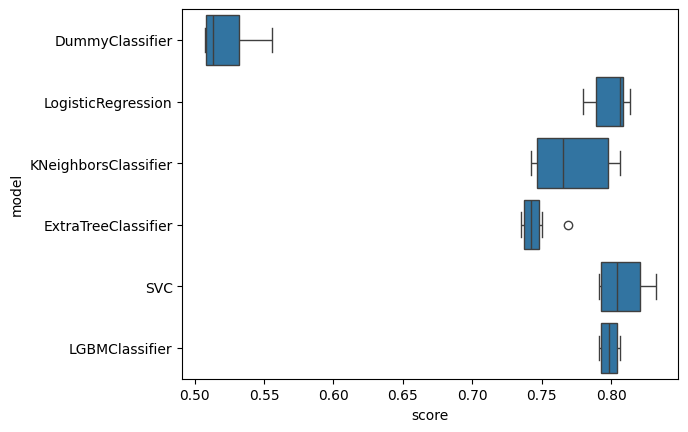

In [505]:
sns.boxplot(data=models_df, x='score', y='model')

<Axes: xlabel='time_elapsed', ylabel='model'>

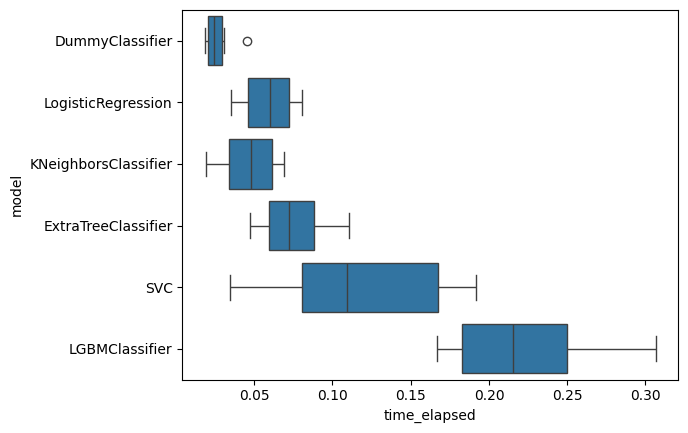

In [506]:
sns.boxplot(data=models_df, x='time_elapsed', y='model')

In [507]:
#getting best params from SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pipe_svc = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', SVC(random_state=1))
            ])

param_range = [0.001,0.01,0.1,1,10,100,1000]
param_grid = {'SVC__C': [0.001,0.01,0.1,1,10,100,1000], 'SVC__kernel': ['linear', 'rbf'],
              'SVC__gamma': [0.001,0.01,0.1,1,10,100,1000]}
cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid, scoring='accuracy', cv = cv, return_train_score=True)
gs.fit(X_train, y_train)

print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))
print("All Test Scores: \n{}\n".format(gs.cv_results_['mean_test_score']))
# # This prints out all results during Cross-Validation in details
#print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))

ValueError: Invalid parameter 'SVC' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('num_trans',
                                                                   Normalizer())]),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Companions', 'FamilySize'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_trans',
                                                                   OneHotEncoder())]),
                                                  Index(['Sex', 'Embarked'], dtype='object'))])),
                ('classifier', SVC(random_state=1))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].